This notebook performs inference on the measurement hour, using imputations obtained for each candidate measurement hour 0, 1, …, 23.
The imputations are obtained on a cluster, and saved in `SAVED_DIR`.

In [1]:
const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"

"/Volumes/Samsung250GB/temperature_model/saved"

In [2]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using JLD
using Distances
using DataFrames: by, head
using Base.Dates: tonext, Hour, Day
using Distributions

In [3]:
include("../src/TempModel.jl")

TempModel

In [4]:
iowa_time(ts) = ts - Hour(6)
ilocaltime = circshift(1:24, -6)
;

In [5]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=400.0)
plt.rc("figure", figsize=(8,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [6]:
data_dir="../"
# obtain the list of stations
logging(DevNull; kind=:warn)
isdList=TempModel.read_isdList(;data_dir=data_dir)
logging()
# just the Iowa stations
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF]],:]

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [7]:
# obtain the hourly temperature measurements for those stations
logging(DevNull; kind=:warn)
hourly_cat=TempModel.read_Stations(isdSubset; data_dir=data_dir)
logging(kind=:warn)
# mark station 3 (Waterloo) as the test station
itest=3
# separate temperatures into train and test
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
# get the USAF code for the test station
test_usaf=isdSubset[itest,:USAF]

725480

In [8]:
hourly_test[:ts_day] = [TempModel.measurement_date(t, Hour(17)) for t in hourly_test[:ts]]
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp]), 
    Tx=maximum(df[:temp])))
;

In [9]:
module Batch
    const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"
    using ..TempModel
    import PyPlot; plt=PyPlot
    using LaTeXStrings
    using DataFrames
    using Base.Dates
    using Distributions
    ;
    include("../src/batch_diagnostics.jl")
    include("../src/plot_diagnostics.jl")
end

Batch

# Getting Mean Imputed Temperature

In [10]:
imputed_ts_dict = Dict{Hour,Vector{Vector{DateTime}}}()
imputed_mean_dict = Dict{Hour,Vector{Vector{Float64}}}()
imputed_window_time = Dict{Hour, Vector{Batch.WindowTime}}()

@time for hr in Hour(0):Hour(1):Hour(23)
    # initialize
    imputed_ts_dict[hr] = Vector{DateTime}[]
    imputed_mean_dict[hr] = Vector{Float64}[]
    imputed_window_time[hr] = Batch.WindowTime[]
    
    println("hour: ", hr)
    for window_num in 1:120
        local chains
        local ts
        
        print(window_num, " - ")
        stan_fw = Batch.get_window(window_num)
        GPmodel = "SExSE"
#                 center_fw = Batch.window_center(stan_fw, Batch.stan_increment)
        try
            chains, ts = Batch.get_chains_and_ts(stan_fw, GPmodel, hr, test_usaf; verbose=false);
        catch
            break
        end
        windowtime = Batch.WindowTime(minimum(ts), maximum(ts))
        temp_impute = Batch.get_temperatures_reparam(chains)
#         arg_center_fw = [(center_fw.start_date <= TempModel.measurement_date(t, hr) <= center_fw.end_date)
#             for t in ts]
#         temp_impute_center = temp_impute[:,arg_center_fw,:]
        mean_imputation = vec(mean(temp_impute, (1,3)))
        @assert length(mean_imputation)==length(ts)
#         @assert length(ts[arg_center_fw])==sum(arg_center_fw)
        push!(imputed_ts_dict[hr], ts)
        push!(imputed_mean_dict[hr], mean_imputation)
        push!(imputed_window_time[hr], windowtime)
    end
    print("\n --- \n")
end

hour: 0 hours
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40 - 41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60 - 61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80 - 81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100 - 101 - 102 - 103 - 104 - 105 - 106 - 107 - 108 - 109 - 110 - 111 - 112 - 113 - 114 - 115 - 116 - 117 - 118 - 119 - 120 - 
 --- 
hour: 1 hour
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40 - 41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60 - 61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 

1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40 - 41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60 - 61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80 - 81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100 - 101 - 102 - 103 - 104 - 105 - 106 - 107 - 108 - 109 - 110 - 111 - 112 - 113 - 114 - 115 - 116 - 117 - 118 - 119 - 120 - 
 --- 
hour: 13 hours
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40 - 41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60 - 61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 

In [11]:
stitched_ts_dict = Dict{Hour,Vector{DateTime}}()
stitched_mean_dict = Dict{Hour,Vector{Float64}}()
@time for hr in Hour(0):Hour(1):Hour(23)    
    impt_windows = imputed_window_time[hr]
    stitched_ts = sort(unique(vcat(imputed_ts_dict[hr]...))) # unique imputed times
    best_impt_window = [Batch.find_best_window(t, impt_windows) for t in stitched_ts]
    
    stitched_mean = Float64[]
    for (iwt, wt) in enumerate(impt_windows)
        its_start, its_end = extrema(find(best_impt_window .== iwt))
        ts_start = stitched_ts[its_start]
        ts_end = stitched_ts[its_end]

        impt_times = imputed_ts_dict[hr][iwt]
        impt_mean = imputed_mean_dict[hr][iwt]
        # indices of times for which this window is the best
        impt_subset = Batch.argsubset(impt_times, ts_start, ts_end, closed_start=true, closed_end=true)
        μ_window = impt_mean[impt_subset]
        append!(stitched_mean, μ_window)
    end
    stitched_ts_dict[hr] = stitched_ts
    stitched_mean_dict[hr] = stitched_mean
end  

  1.757889 seconds (5.36 M allocations: 1.497 GiB, 23.99% gc time)


In [12]:
[(k, length(v)) for (k,v) in collect(stitched_ts_dict)]

24-element Array{Tuple{Base.Dates.Hour,Int64},1}:
 (21 hours, 12607)
 (6 hours, 12580) 
 (14 hours, 12595)
 (16 hours, 12597)
 (5 hours, 12578) 
 (2 hours, 12569) 
 (13 hours, 12592)
 (20 hours, 12605)
 (22 hours, 12608)
 (23 hours, 12610)
 (3 hours, 12574) 
 (12 hours, 12591)
 (7 hours, 12581) 
 (0 hours, 12564) 
 (15 hours, 12596)
 (8 hours, 12583) 
 (19 hours, 12603)
 (17 hours, 12599)
 (11 hours, 12588)
 (18 hours, 12602)
 (10 hours, 12587)
 (4 hours, 12577) 
 (9 hours, 12585) 
 (1 hour, 12566)  

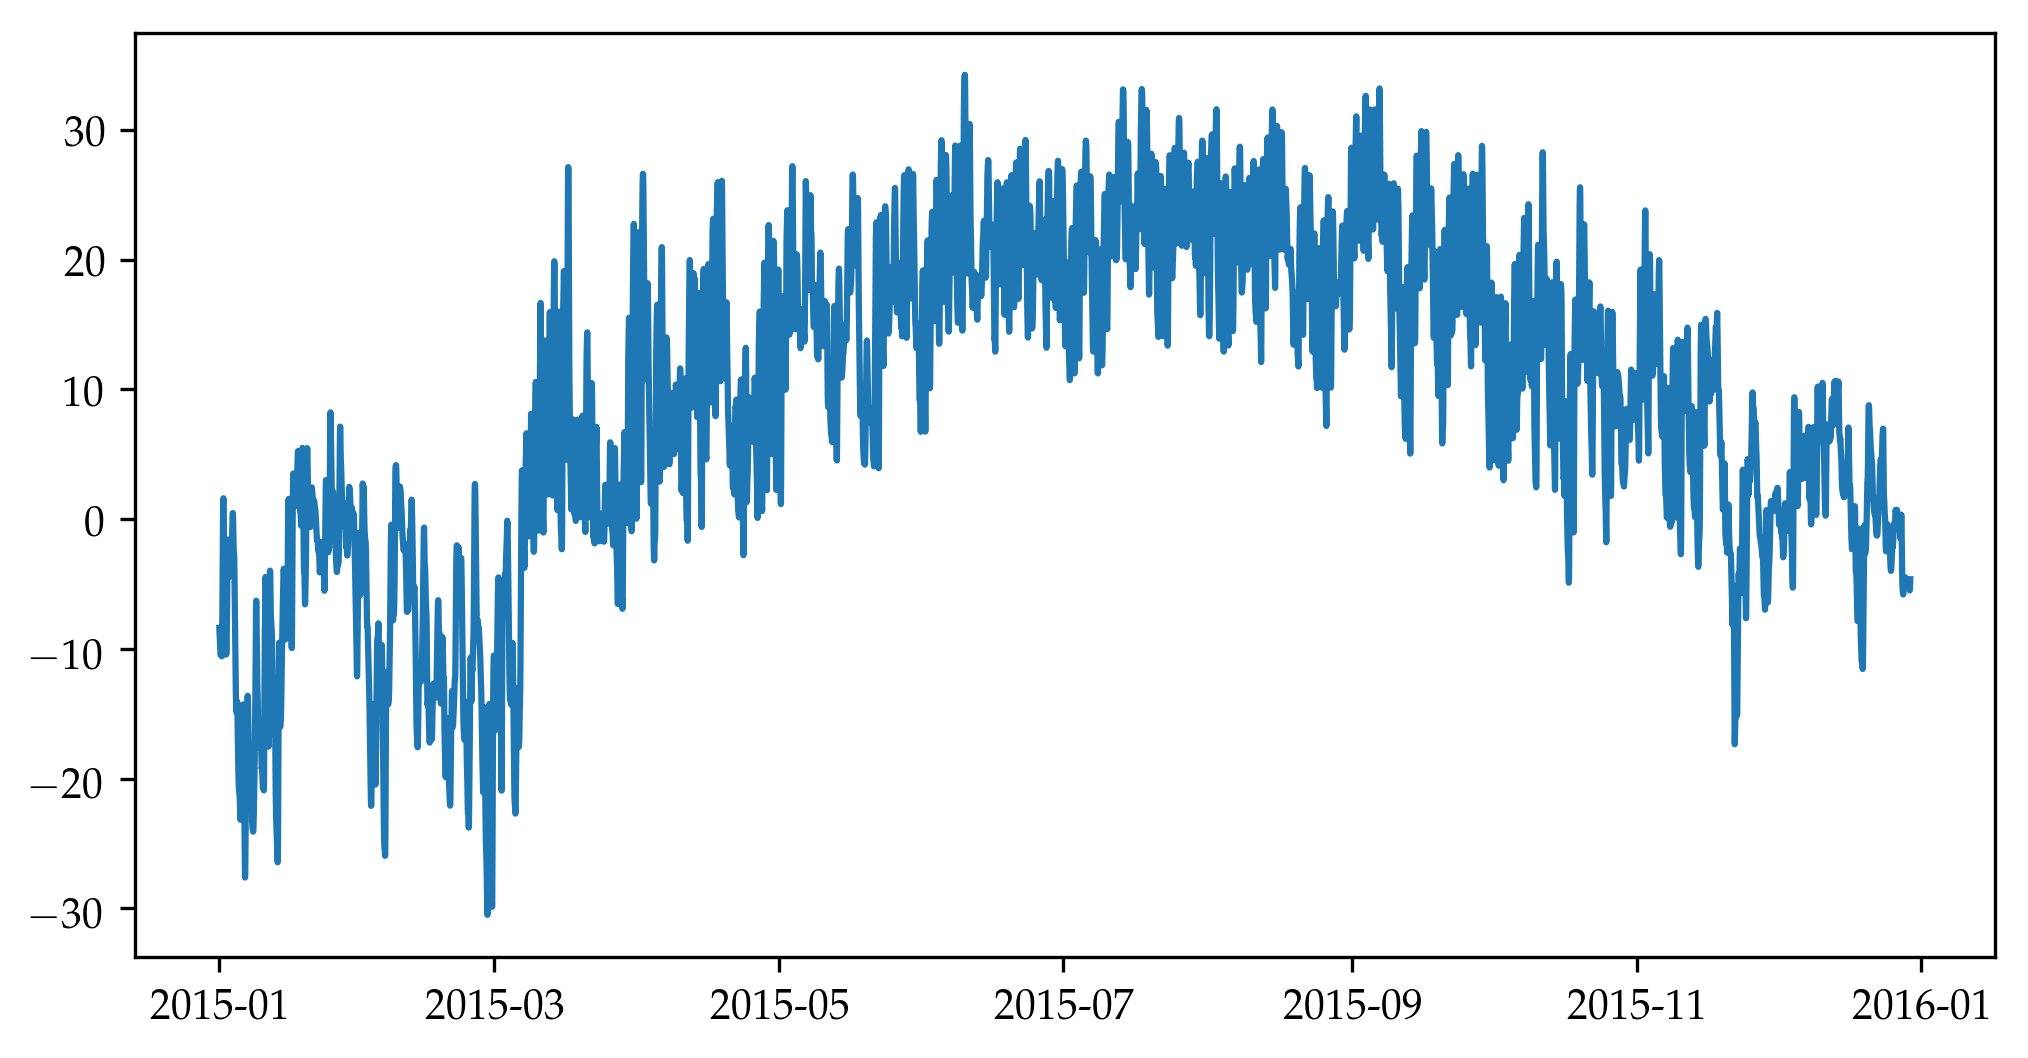

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x134e5f9b0>

In [13]:
hr = Hour(17)
plt.plot(stitched_ts_dict[hr], stitched_mean_dict[hr])

# Nearby Predictions

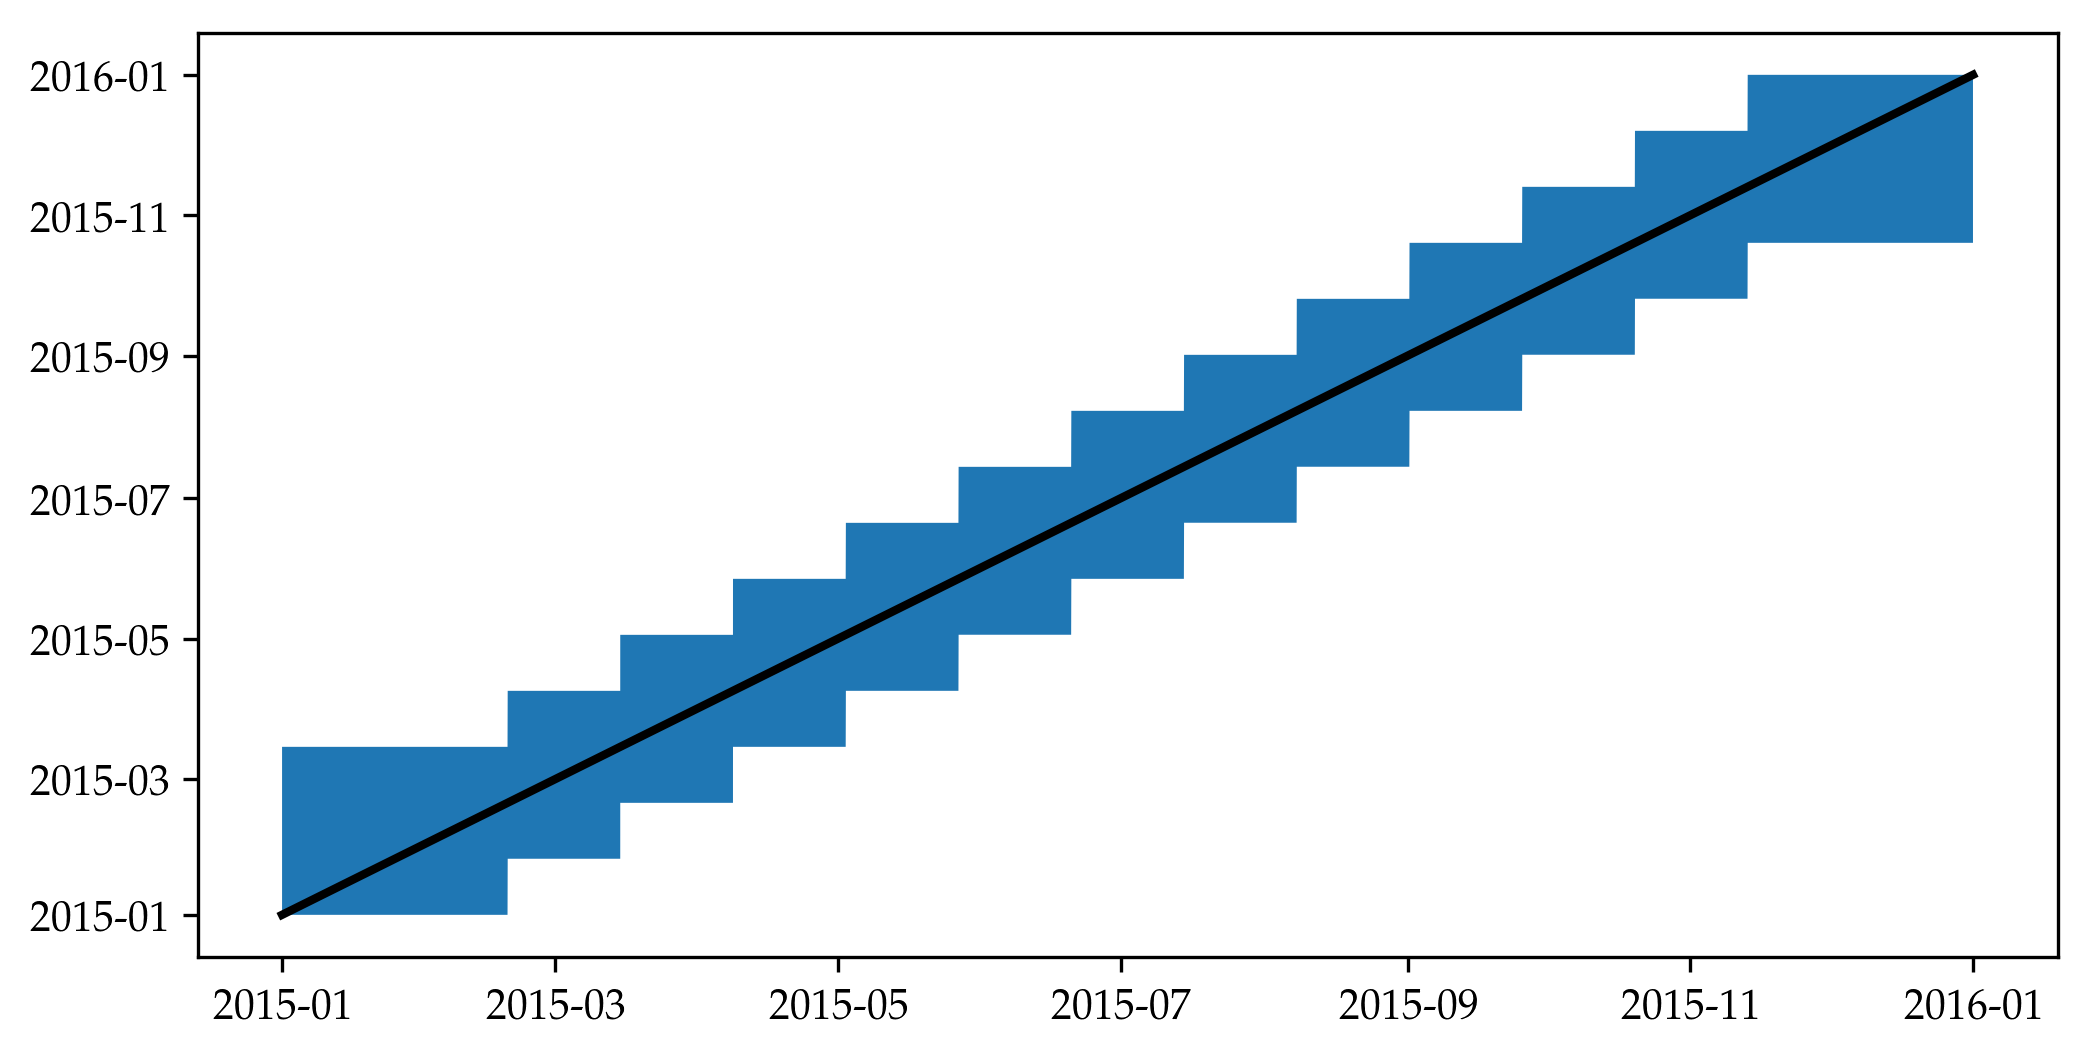

In [14]:
nearby_windows = [
    Batch.FittingWindow(Date(2015,1,1),Date(2015,3,14)),
    Batch.FittingWindow(Date(2015,1,25),Date(2015,4,8)),
    Batch.FittingWindow(Date(2015,2,18),Date(2015,5,2)),
    Batch.FittingWindow(Date(2015,3,14),Date(2015,5,26)),
    Batch.FittingWindow(Date(2015,4,8),Date(2015,6,20)),
    Batch.FittingWindow(Date(2015,5,2),Date(2015,7,14)),
    Batch.FittingWindow(Date(2015,5,26),Date(2015,8,7)),
    Batch.FittingWindow(Date(2015,6,20),Date(2015,9,1)),
    Batch.FittingWindow(Date(2015,7,14),Date(2015,9,25)),
    Batch.FittingWindow(Date(2015,8,7),Date(2015,10,19)),
    Batch.FittingWindow(Date(2015,9,1),Date(2015,11,13)),
    Batch.FittingWindow(Date(2015,9,25),Date(2015,12,7)),
    Batch.FittingWindow(Date(2015,10,19),Date(2015,12,31)),
]
;

GPmodel = "SExSE"
test_ts = hourly_test[:ts];
all_nearby_preds = TempModel.NearbyPrediction[]
for fw in nearby_windows
    push!(all_nearby_preds, Batch.get_nearby(fw, GPmodel, test_usaf))
end
nearby_window_times = [Batch.WindowTime(np.ts[1], np.ts[end]) for np in all_nearby_preds]
best_pred_window = [Batch.find_best_window(t, nearby_window_times) for t in test_ts]
plt.fill_between(test_ts, 
    [w.start_time for w in nearby_window_times[best_pred_window]],
    [w.end_time   for w in nearby_window_times[best_pred_window]]
    )
plt.plot(test_ts, test_ts, color="black", linewidth=2)
;

In [35]:
(nearby_window_times[4].end_time - nearby_window_times[4].start_time) / Millisecond(Day(1))

72.99583333333334

In [41]:
((maximum(hourly_cat[:ts])-minimum(hourly_cat[:ts])) / 15) / Millisecond(Day(1))

24.333055555555557

In [39]:
(nearby_window_times[4].end_time - nearby_window_times[5].start_time) / Millisecond(Day(1))

48.65833333333333

In [15]:
stitched_nearby_mean = Float64[]
for (ifw, nearby_pred) in enumerate(all_nearby_preds)
    ts_start, ts_end = extrema(t for (i,t) in enumerate(test_ts) if best_pred_window[i] == ifw)
    nrby_subset = Batch.argsubset(nearby_pred.ts, ts_start, ts_end, closed_start=true, closed_end=true)

    μ_window = nearby_pred.μ[nrby_subset]
    append!(stitched_nearby_mean, μ_window)
end

@assert length(test_ts) == length(stitched_nearby_mean)

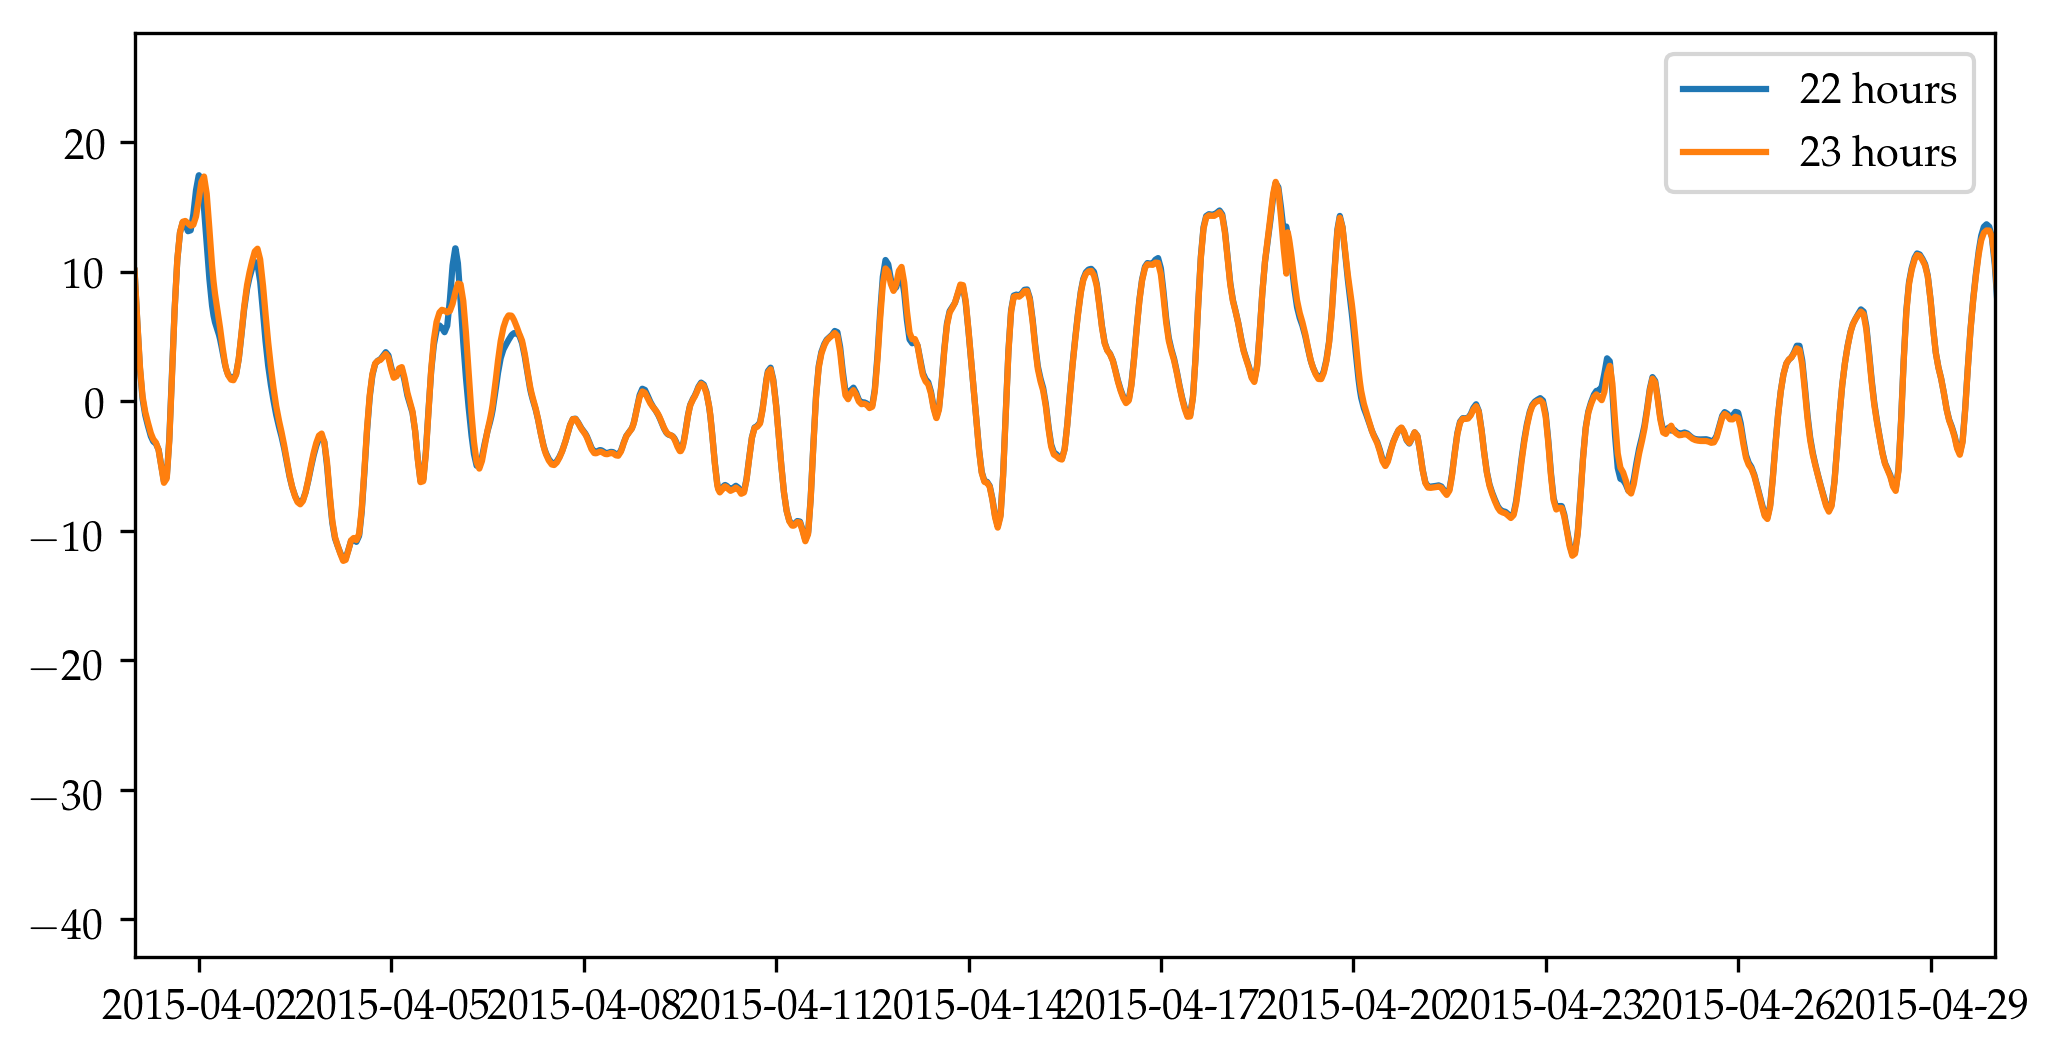

PyObject <matplotlib.legend.Legend object at 0x130b43d30>

In [17]:
plt.xlim(DateTime(2015,4,1,0,0,0),DateTime(2015,4,30,0,0,0))

for hr in (Hour(22), Hour(23))
    stitched_ts_ = stitched_ts_dict[hr]
    stitched_mean = stitched_mean_dict[hr]
    plt.plot(stitched_ts_, stitched_mean.-mean(stitched_mean),"-", label=@sprintf("%s",hr))
end
plt.legend(loc="best")

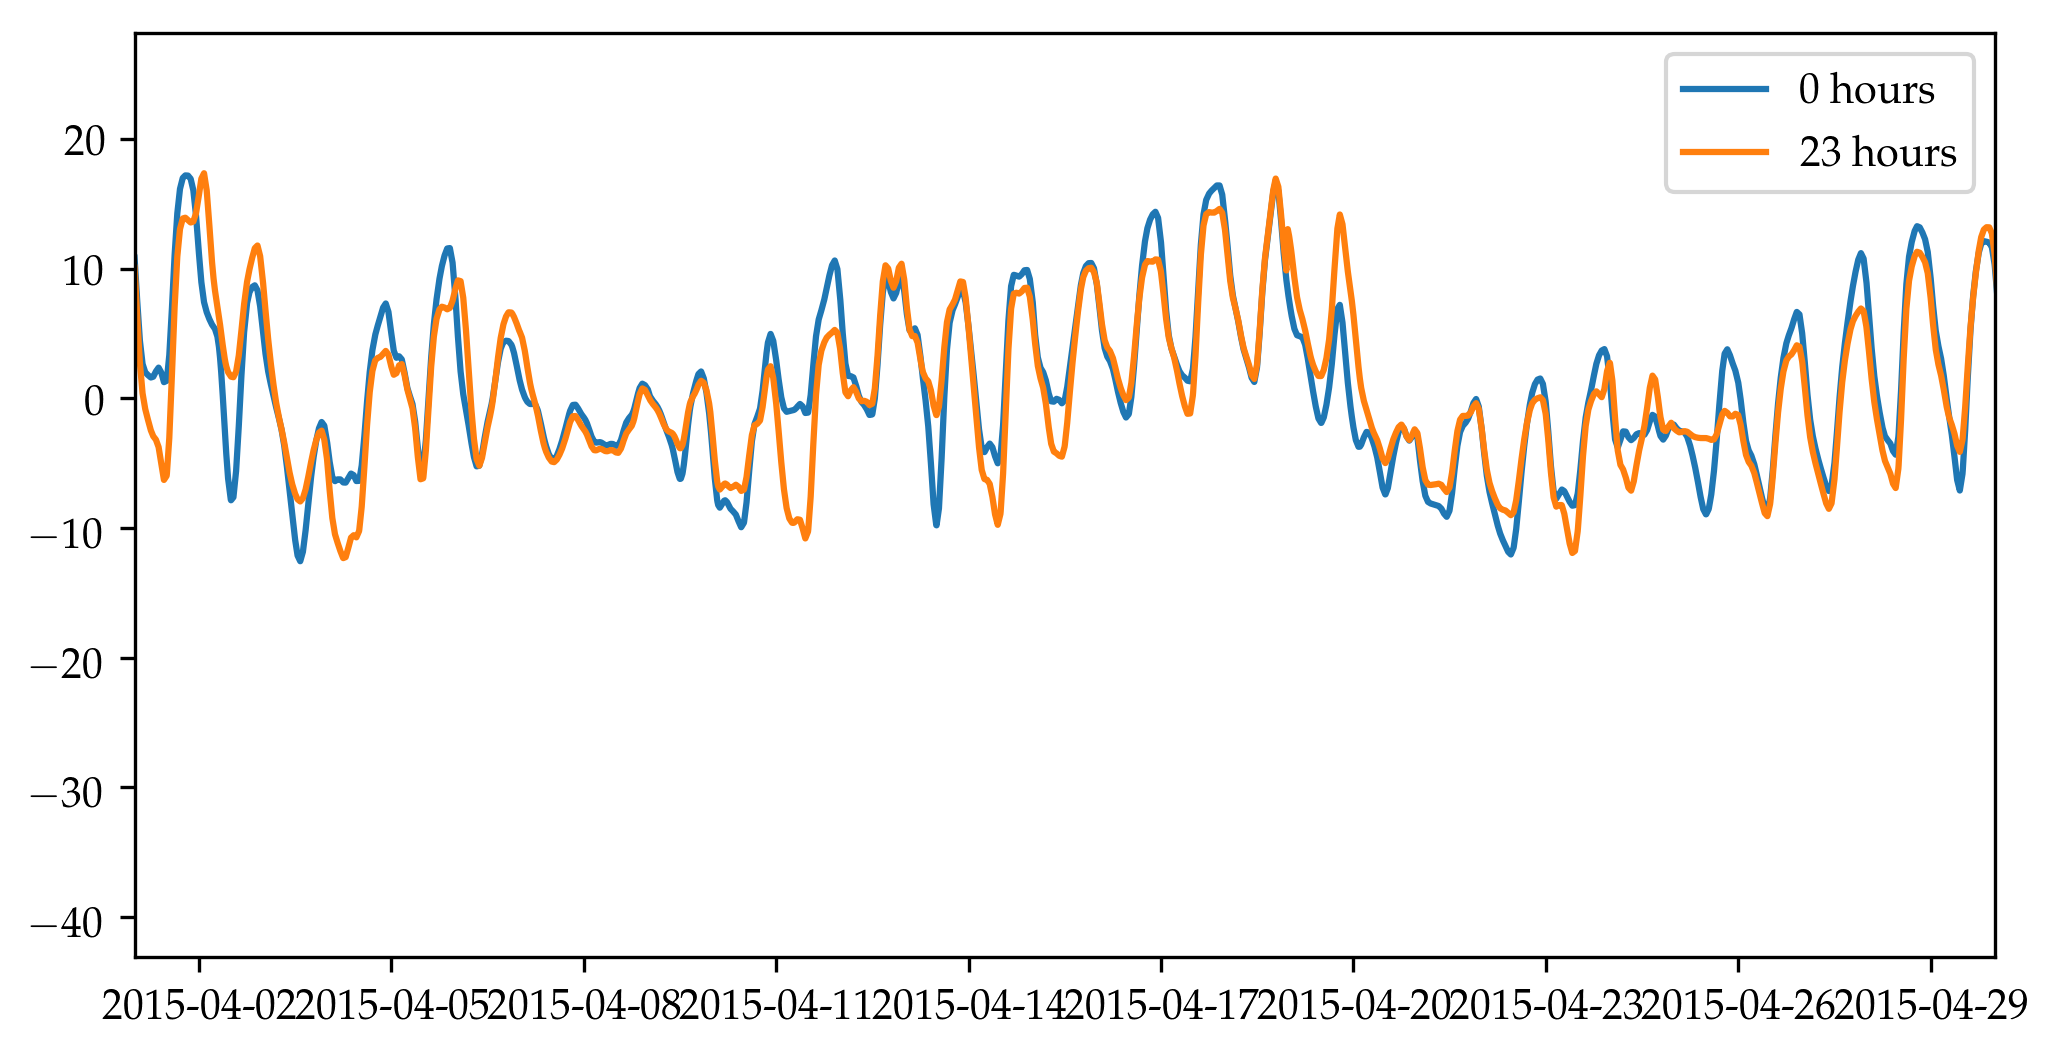

PyObject <matplotlib.legend.Legend object at 0x138165c88>

In [18]:
plt.xlim(DateTime(2015,4,1,0,0,0),DateTime(2015,4,30,0,0,0))

for hr in (Hour(0), Hour(23))
    stitched_ts_ = stitched_ts_dict[hr]
    stitched_mean = stitched_mean_dict[hr]
    plt.plot(stitched_ts_, stitched_mean.-mean(stitched_mean),"-", label=@sprintf("%s",hr))
end
plt.legend(loc="best")

# Visualizing Imputations

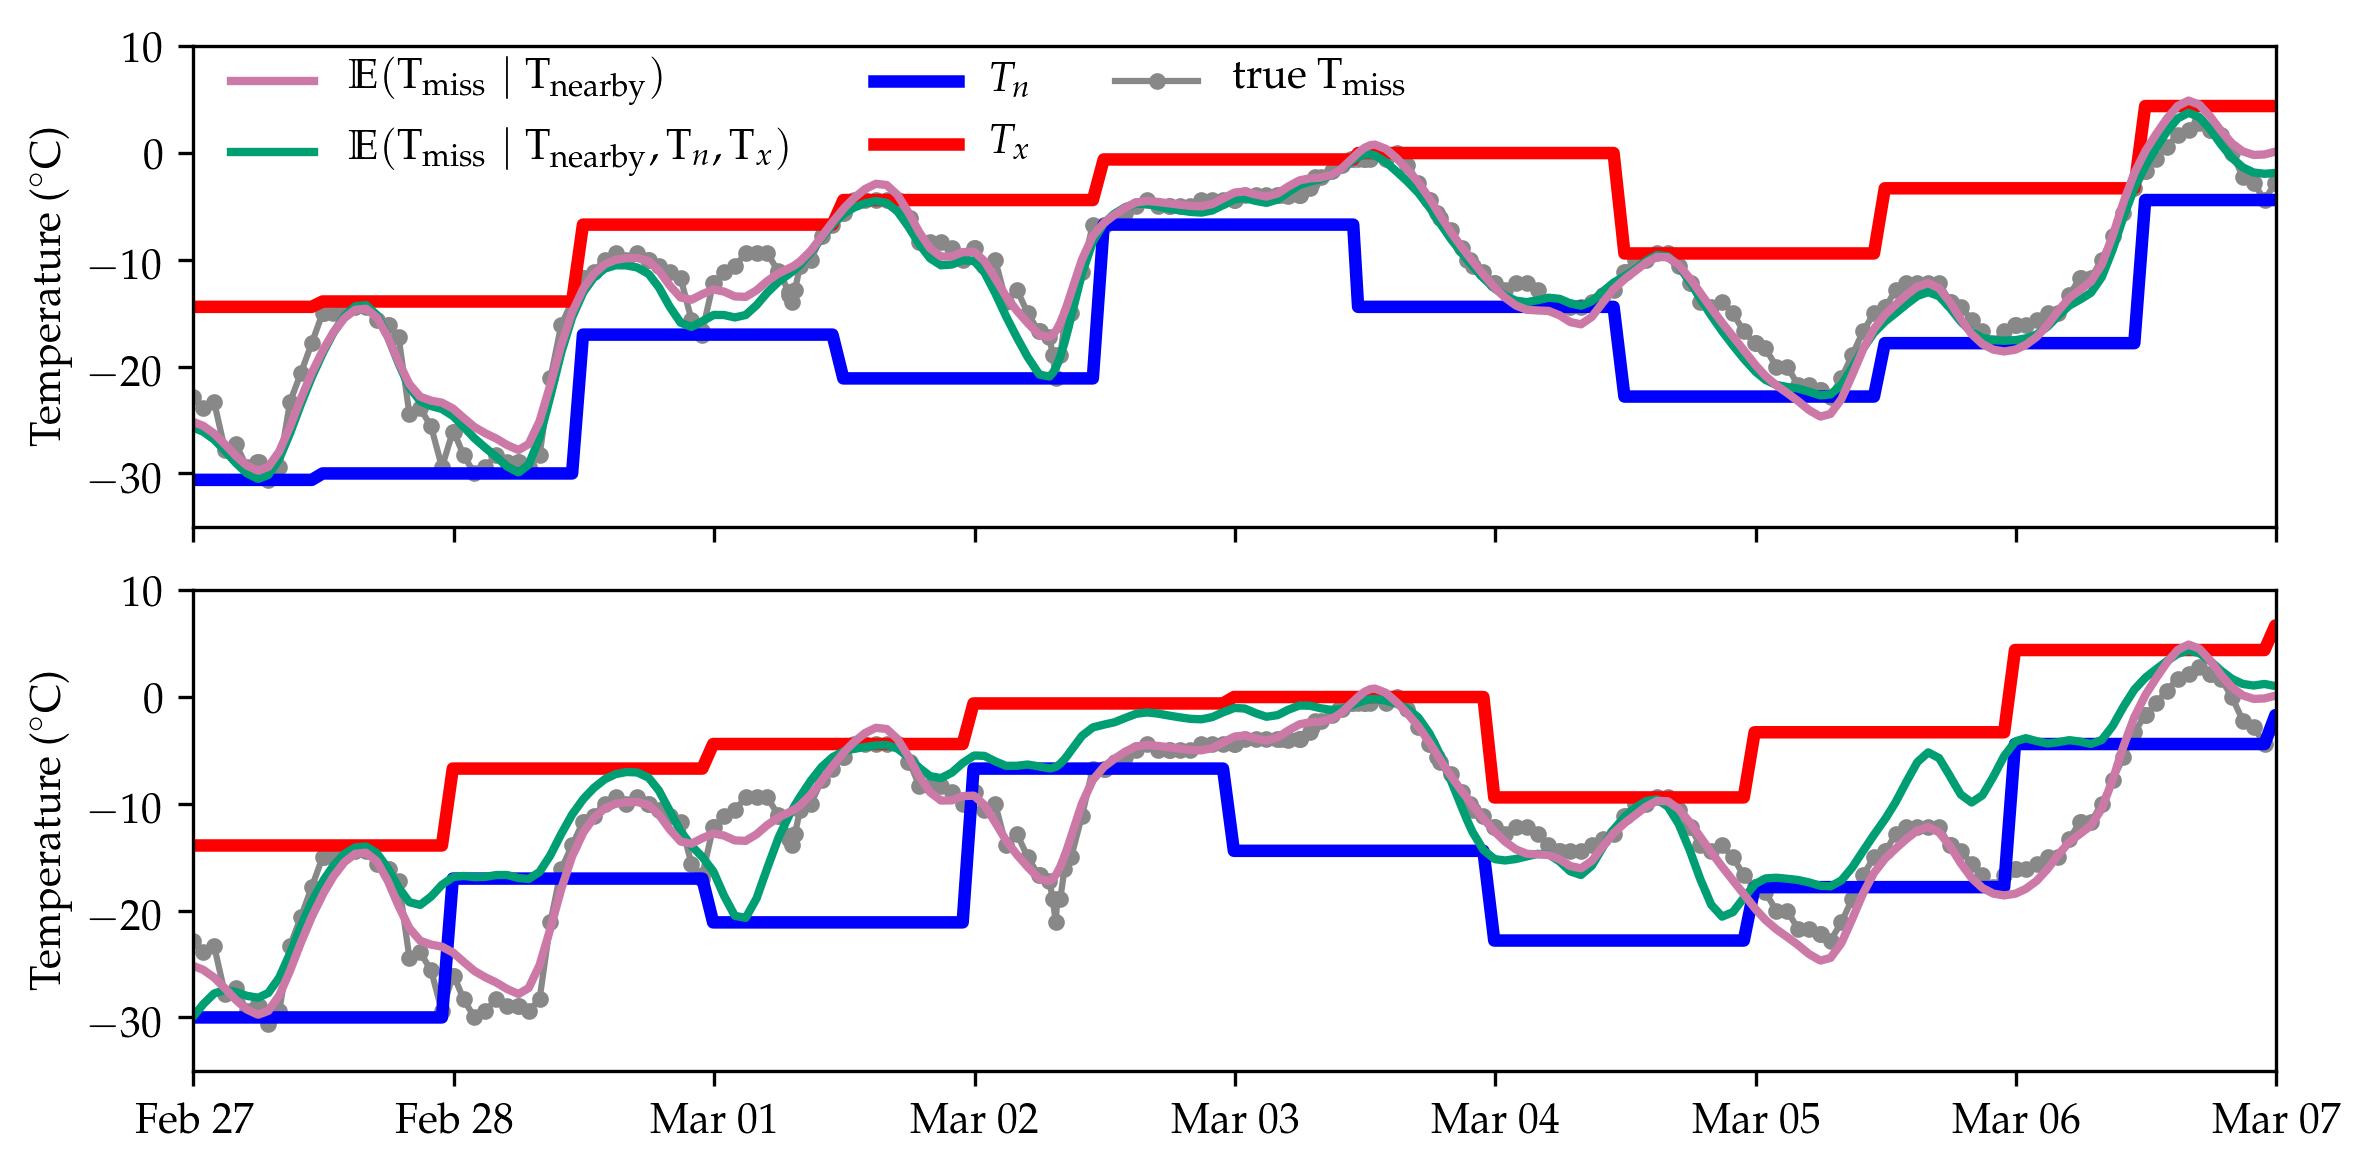

In [44]:
xlim_UTC = [DateTime(2015,2,27,6,0,0), DateTime(2015,3,7,6,0,0)]
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
for (ihr,hr) in enumerate((Hour(17),Hour(5)))
    plt.subplot(2,1,ihr)
    
    stitched_ts = stitched_ts_dict[hr]
    nearby_ts = test_ts
    stitched_mean = stitched_mean_dict[hr]
    nearby_subset = Batch.argsubset(nearby_ts, xlim_UTC[1], xlim_UTC[2], closed_start=true, closed_end=true)
    nearby_ts_subset = nearby_ts[nearby_subset]
    
    hourly_test[:ts_day] = [TempModel.measurement_date(t, hr) for t in hourly_test[:ts]]
    test_TnTx = join(hourly_test[nearby_subset,:], TnTx, on=:ts_day)
    truth_subset = test_TnTx[:temp]
    
    plt.plot(iowa_time.(nearby_ts_subset), truth_subset, 
        color="#888888", ".-", label=L"true $\mathrm{T}_{\mathrm{miss}}$")
    plt.plot(iowa_time.(nearby_ts_subset), test_TnTx[:Tn], 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(iowa_time.(nearby_ts_subset), test_TnTx[:Tx], 
        color="red", linewidth=3, label=L"$T_x$")
    
    impute_subset = Batch.argsubset(iowa_time.(stitched_ts), xlim_UTC[1], xlim_UTC[2], closed_start=true, closed_end=true)
    nearby_stitched_sub = stitched_nearby_mean[nearby_subset]
    nearby_stitched_sub .+= mean(truth_subset) .- mean(nearby_stitched_sub)
    plt.plot(iowa_time.(stitched_ts), stitched_mean, "-", 
        linewidth=2,color=cbbPalette[3],
        label=L"$\mathbb{E}( \mathrm{T}_{\mathrm{miss}} \mid \mathrm{T}_{\mathrm{nearby}}, \mathrm{T}_{n}, \mathrm{T}_{x})$")
    plt.plot(iowa_time.(nearby_ts_subset), nearby_stitched_sub, 
        color=cbbPalette[7], linewidth=2, 
        label=L"$\mathbb{E}( \mathrm{T}_{\mathrm{miss}} \mid \mathrm{T}_{\mathrm{nearby}})$")
    plt.ylabel(L"Temperature (${}^\circ \mathrm{C}$)")
    plt.xlim(iowa_time.(xlim_UTC))
    plt.ylim(-35,10)
    
    plt.gca()[:xaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%b %d"))
#     plt.grid(true, axis="x")
end
plt.subplot(2,1,1)
handles, labels = plt.gca()[:get_legend_handles_labels]()
leg_order = [5,4,2,3,1]
plt.gca()[:set_xticklabels]([])
plt.legend(handles[leg_order], labels[leg_order],
           loc="upper left",
           facecolor="white",
           bbox_to_anchor=[0.0, 1.06],
           framealpha=0.0,
           fontsize=10,
           ncol=3
           )
plt.subplot(2,1,2)


plt.gcf()[:tight_layout]()
plt.savefig("../figures/measure_hour_example.png")
plt.savefig("../figures/measure_hour_example.pdf")

# Obtaining log-likelihoods

In [23]:
function ts_to_hours(ts_datetime::Vector{DateTime})
    ms_per_hour = Millisecond(Hour(1)) / Millisecond(1)
    ts_vec = Float64.((Millisecond.(ts_datetime.-minimum(ts_datetime)) ./ Millisecond(1)) ./ ms_per_hour)
    return ts_vec
end

ts_to_hours (generic function with 1 method)

In [24]:
common_ts_min = max((stitched_ts[1] for stitched_ts in values(stitched_ts_dict))...)
common_ts_max = min((stitched_ts[end] for stitched_ts in values(stitched_ts_dict))...)

kernel_slow = SEIso(log(48.0),log(5.0))
logNoise = 0.0
sumloglik_dict = Dict{Hour,Float64}()
for hr in sort(collect(keys(stitched_ts_dict)))
    stitched_ts = stitched_ts_dict[hr]
    stitched_mean = stitched_mean_dict[hr]
    best_pred_window = [Batch.find_best_window(t, nearby_window_times) for t in stitched_ts]
    println("===========================================")
    println(hr)
    println("---------------")
    sumloglik = 0.0
    for (ifw, nearby_pred) in enumerate(all_nearby_preds)
        ts_start, ts_end = extrema(t for (i,t) in enumerate(stitched_ts) if best_pred_window[i] == ifw)
        
        # but don't do this for predictions that aren't common to all sets of imputations
        ts_start = max(ts_start, common_ts_min)
        ts_end   = min(ts_end,   common_ts_max)

        nrby_subset = Batch.argsubset(nearby_pred.ts, ts_start, ts_end, closed_start=true, closed_end=true)
        impt_subset = Batch.argsubset(stitched_ts,    ts_start, ts_end, closed_start=true, closed_end=true)
        @assert sum(nrby_subset) == sum(impt_subset)

        μ_window = nearby_pred.μ[nrby_subset]
        Σ_window = nearby_pred.Σ.mat[nrby_subset,nrby_subset]
        
#         for i in 1:sum(nrby_subset)
#             Σ_window[i,i] += exp(2*logNoise)
#         end
        ts_window = stitched_ts[impt_subset]
        ts_hours = ts_to_hours(ts_window)
        GaussianProcesses.addcov!(Σ_window, kernel_slow, ts_hours')
        
        μ_window .-= mean(μ_window)
        nearby_distr = MultivariateNormal(μ_window, Σ_window)

        mean_impt = stitched_mean[impt_subset]
        mean_impt .-= mean(mean_impt)
        μ_logpdf    = logpdf(nearby_distr,μ_window)
        impt_logpdf = logpdf(nearby_distr,mean_impt)
        @printf("difference in log-pdf: %12.3f (%d points)\n", impt_logpdf-μ_logpdf, sum(nrby_subset))
        sumloglik += impt_logpdf-μ_logpdf
    end
    println("---------------")
    @printf("Sum of log-likelihood difference: %5.3f\n", sumloglik)
    sumloglik_dict[hr] = sumloglik
end

0 hours
---------------
difference in log-pdf:    -1461.488 (1761 points)
difference in log-pdf:     -886.578 (763 points)
difference in log-pdf:     -273.738 (799 points)
difference in log-pdf:     -269.819 (775 points)
difference in log-pdf:     -363.033 (952 points)
difference in log-pdf:     -214.562 (862 points)
difference in log-pdf:     -185.705 (881 points)
difference in log-pdf:     -168.724 (788 points)
difference in log-pdf:     -167.307 (861 points)
difference in log-pdf:     -200.111 (742 points)
difference in log-pdf:     -325.323 (722 points)
difference in log-pdf:     -493.640 (840 points)
difference in log-pdf:     -700.916 (1818 points)
---------------
Sum of log-likelihood difference: -5710.944
1 hour
---------------
difference in log-pdf:    -1521.892 (1761 points)
difference in log-pdf:     -719.191 (763 points)
difference in log-pdf:     -242.833 (799 points)
difference in log-pdf:     -264.647 (775 points)
difference in log-pdf:     -331.985 (952 points)
differen

difference in log-pdf:     -193.407 (722 points)
difference in log-pdf:     -254.790 (840 points)
difference in log-pdf:     -379.202 (1818 points)
---------------
Sum of log-likelihood difference: -2981.194
11 hours
---------------
difference in log-pdf:     -542.726 (1761 points)
difference in log-pdf:     -431.199 (763 points)
difference in log-pdf:     -120.000 (799 points)
difference in log-pdf:     -170.384 (775 points)
difference in log-pdf:     -136.839 (952 points)
difference in log-pdf:      -64.730 (862 points)
difference in log-pdf:      -54.526 (881 points)
difference in log-pdf:      -64.781 (788 points)
difference in log-pdf:     -104.658 (861 points)
difference in log-pdf:     -107.026 (742 points)
difference in log-pdf:     -184.812 (722 points)
difference in log-pdf:     -243.164 (840 points)
difference in log-pdf:     -339.161 (1818 points)
---------------
Sum of log-likelihood difference: -2564.007
12 hours
---------------
difference in log-pdf:     -466.534 (1761 p

difference in log-pdf:      -67.377 (862 points)
difference in log-pdf:      -78.485 (881 points)
difference in log-pdf:      -70.564 (788 points)
difference in log-pdf:      -56.318 (861 points)
difference in log-pdf:      -82.355 (742 points)
difference in log-pdf:     -175.265 (722 points)
difference in log-pdf:     -156.035 (840 points)
difference in log-pdf:     -146.821 (1818 points)
---------------
Sum of log-likelihood difference: -1935.789
22 hours
---------------
difference in log-pdf:     -382.149 (1761 points)
difference in log-pdf:     -210.014 (763 points)
difference in log-pdf:     -403.360 (799 points)
difference in log-pdf:     -124.333 (775 points)
difference in log-pdf:     -246.227 (952 points)
difference in log-pdf:      -95.942 (862 points)
difference in log-pdf:      -95.921 (881 points)
difference in log-pdf:      -77.818 (788 points)
difference in log-pdf:      -64.470 (861 points)
difference in log-pdf:     -104.422 (742 points)
difference in log-pdf:     -210

# Plots of Concordance Measure

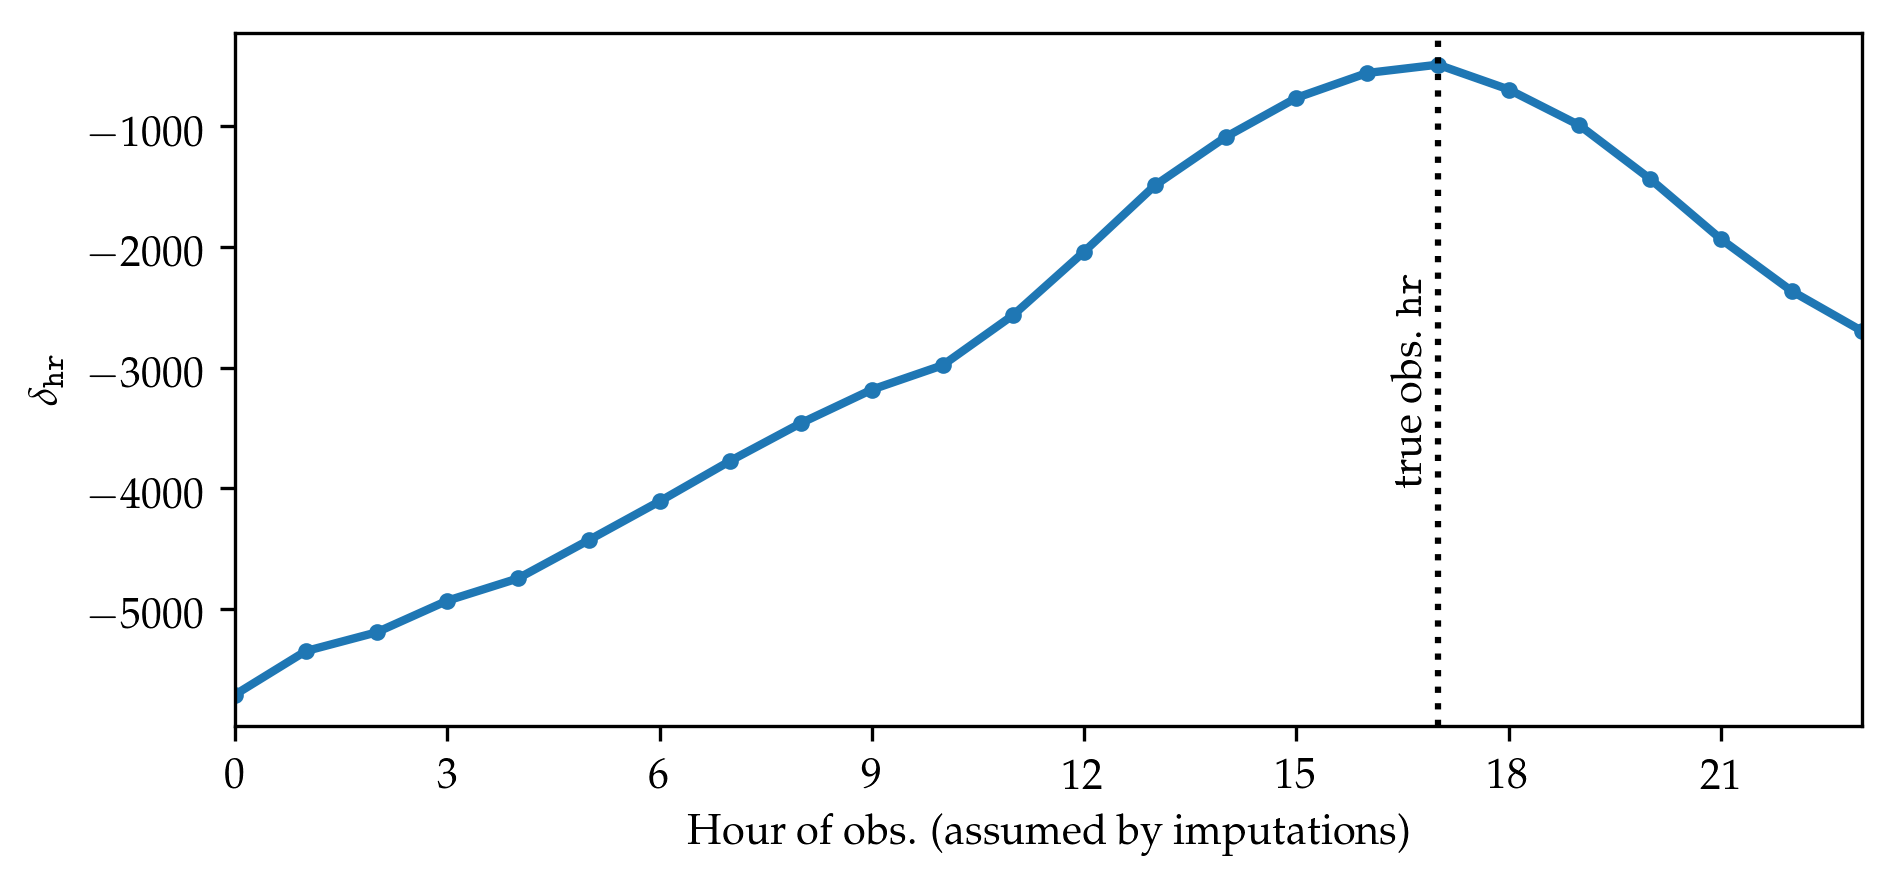

(0, 23)

In [25]:
plt.gcf()[:set_size_inches](7.0, 3.0)
hours_vec = sort(collect(keys(sumloglik_dict)))
hours_floats = [h/Hour(1) for h in hours_vec]
sumloglik_vec = [sumloglik_dict[hr] for hr in hours_vec]
plt.plot(hours_floats, sumloglik_vec, ".-", linewidth=2)
plt.axvline(17, linestyle=":", color="black")
plt.xlabel("Hour of obs. (assumed by imputations)")
plt.ylabel(L"$\delta_{\mathtt{hr}}$")
# plt.text(3, -1000, 
#     L"\log \mathbb{P}\left( \mathrm{T}_{\mathrm{miss}} = \mathbb{E}\left( \mathrm{T}_{\mathrm{miss}} \mid \mathrm{T}_{\mathrm{nearby}}, \mathrm{T}_{n}, \mathrm{T}_{x}, \mathtt{hour}, \hat{\theta} \right) \mid \mathrm{T}_{\mathrm{nearby}}, \hat{\theta} \right)")
plt.text(16.9,-4000, L"true obs. $\mathtt{hr}$", rotation=90.0, horizontalalignment="right",
    verticalalignment="bottom"
    )
plt.xticks(0:3:24, 0:3:24)
plt.xlim(0,23)

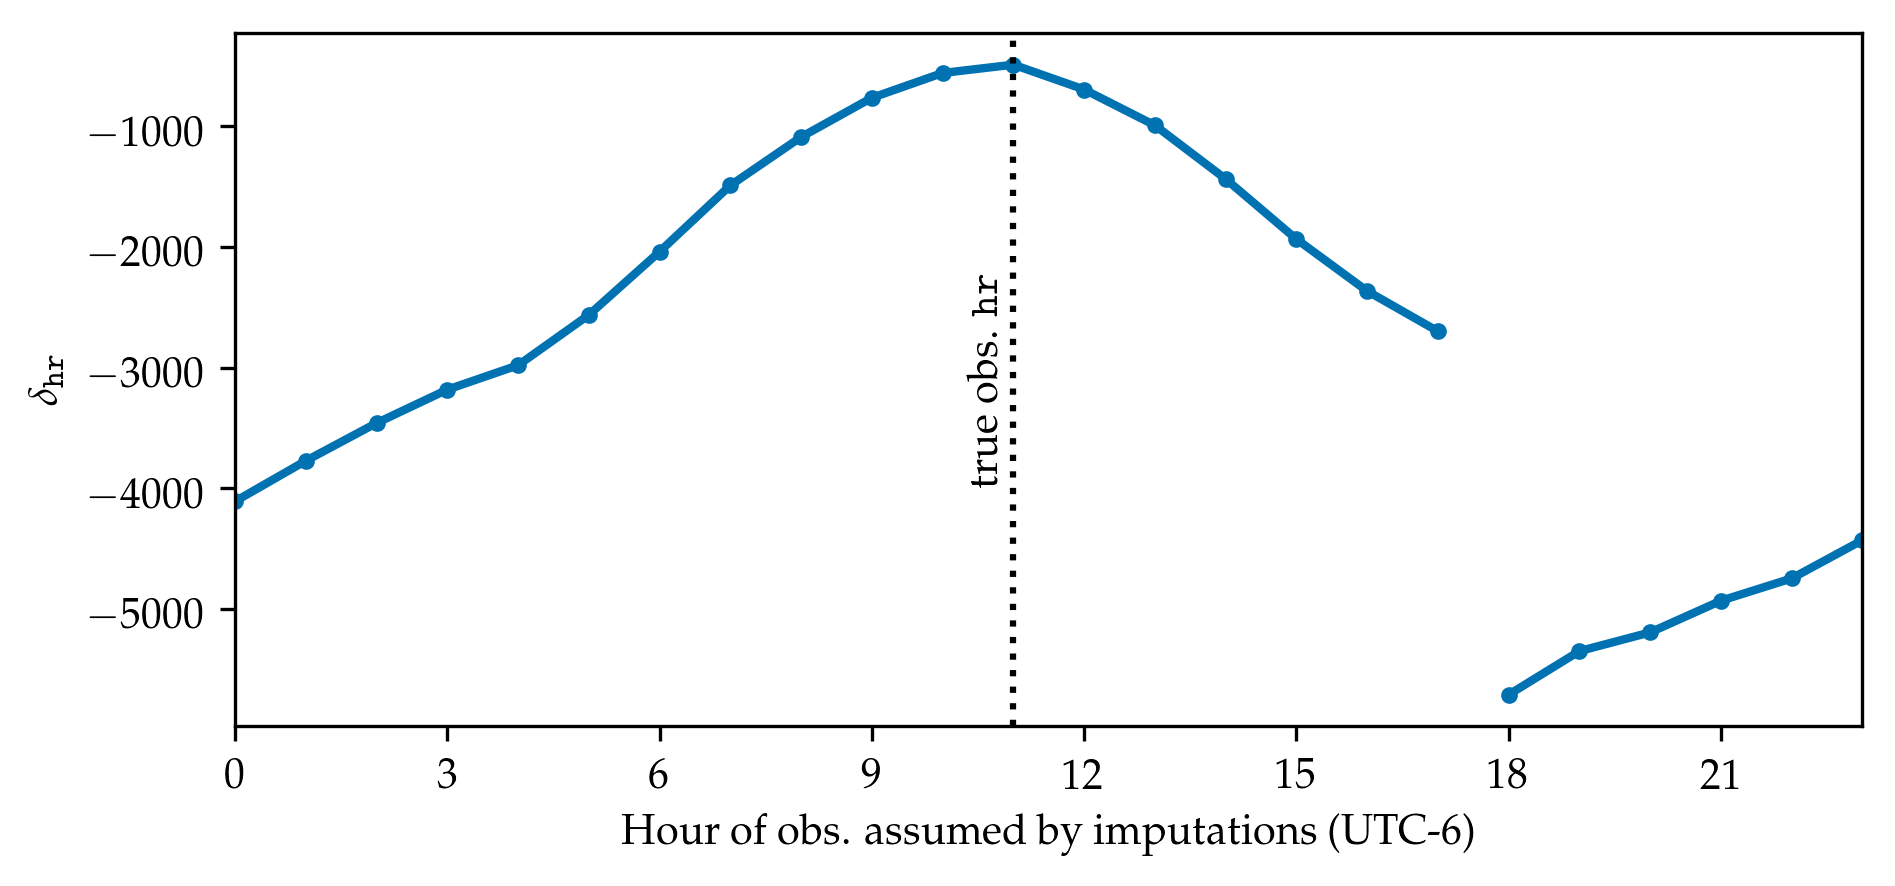

In [26]:
plt.gcf()[:set_size_inches](7.0, 3.0)
hours_vec = sort(collect(keys(sumloglik_dict)))
hours_floats = [h/Hour(1) for h in hours_vec]
sumloglik_vec = [sumloglik_dict[hr] for hr in hours_vec]
plt.plot(hours_floats[1:18], sumloglik_vec[ilocaltime][1:18], color=cbbPalette[5], ".-", linewidth=2)
plt.plot(hours_floats[19:end], sumloglik_vec[ilocaltime][19:end], color=cbbPalette[5], ".-", linewidth=2)
hr17_f64 = iowa_time(Hour(17))/Hour(1)
plt.axvline(hr17_f64, linestyle=":", color="black")
plt.xlabel("Hour of obs. assumed by imputations (UTC-6)")
plt.ylabel(L"$\delta_{\mathtt{hr}}$")
# plt.text(3, -1000, 
#     L"\log \mathbb{P}\left( \mathrm{T}_{\mathrm{miss}} = \mathbb{E}\left( \mathrm{T}_{\mathrm{miss}} \mid \mathrm{T}_{\mathrm{nearby}}, \mathrm{T}_{n}, \mathrm{T}_{x}, \mathtt{hour}, \hat{\theta} \right) \mid \mathrm{T}_{\mathrm{nearby}}, \hat{\theta} \right)")
plt.text(hr17_f64-0.1,-4000, L"true obs. $\mathtt{hr}$", rotation=90.0, horizontalalignment="right",
    verticalalignment="bottom"
    )
plt.xticks(0:3:24, 0:3:24)
plt.xlim(0,23)
plt.savefig("../figures/hr_inference.png", bbox_inches="tight")
plt.savefig("../figures/hr_inference.pdf", bbox_inches="tight")

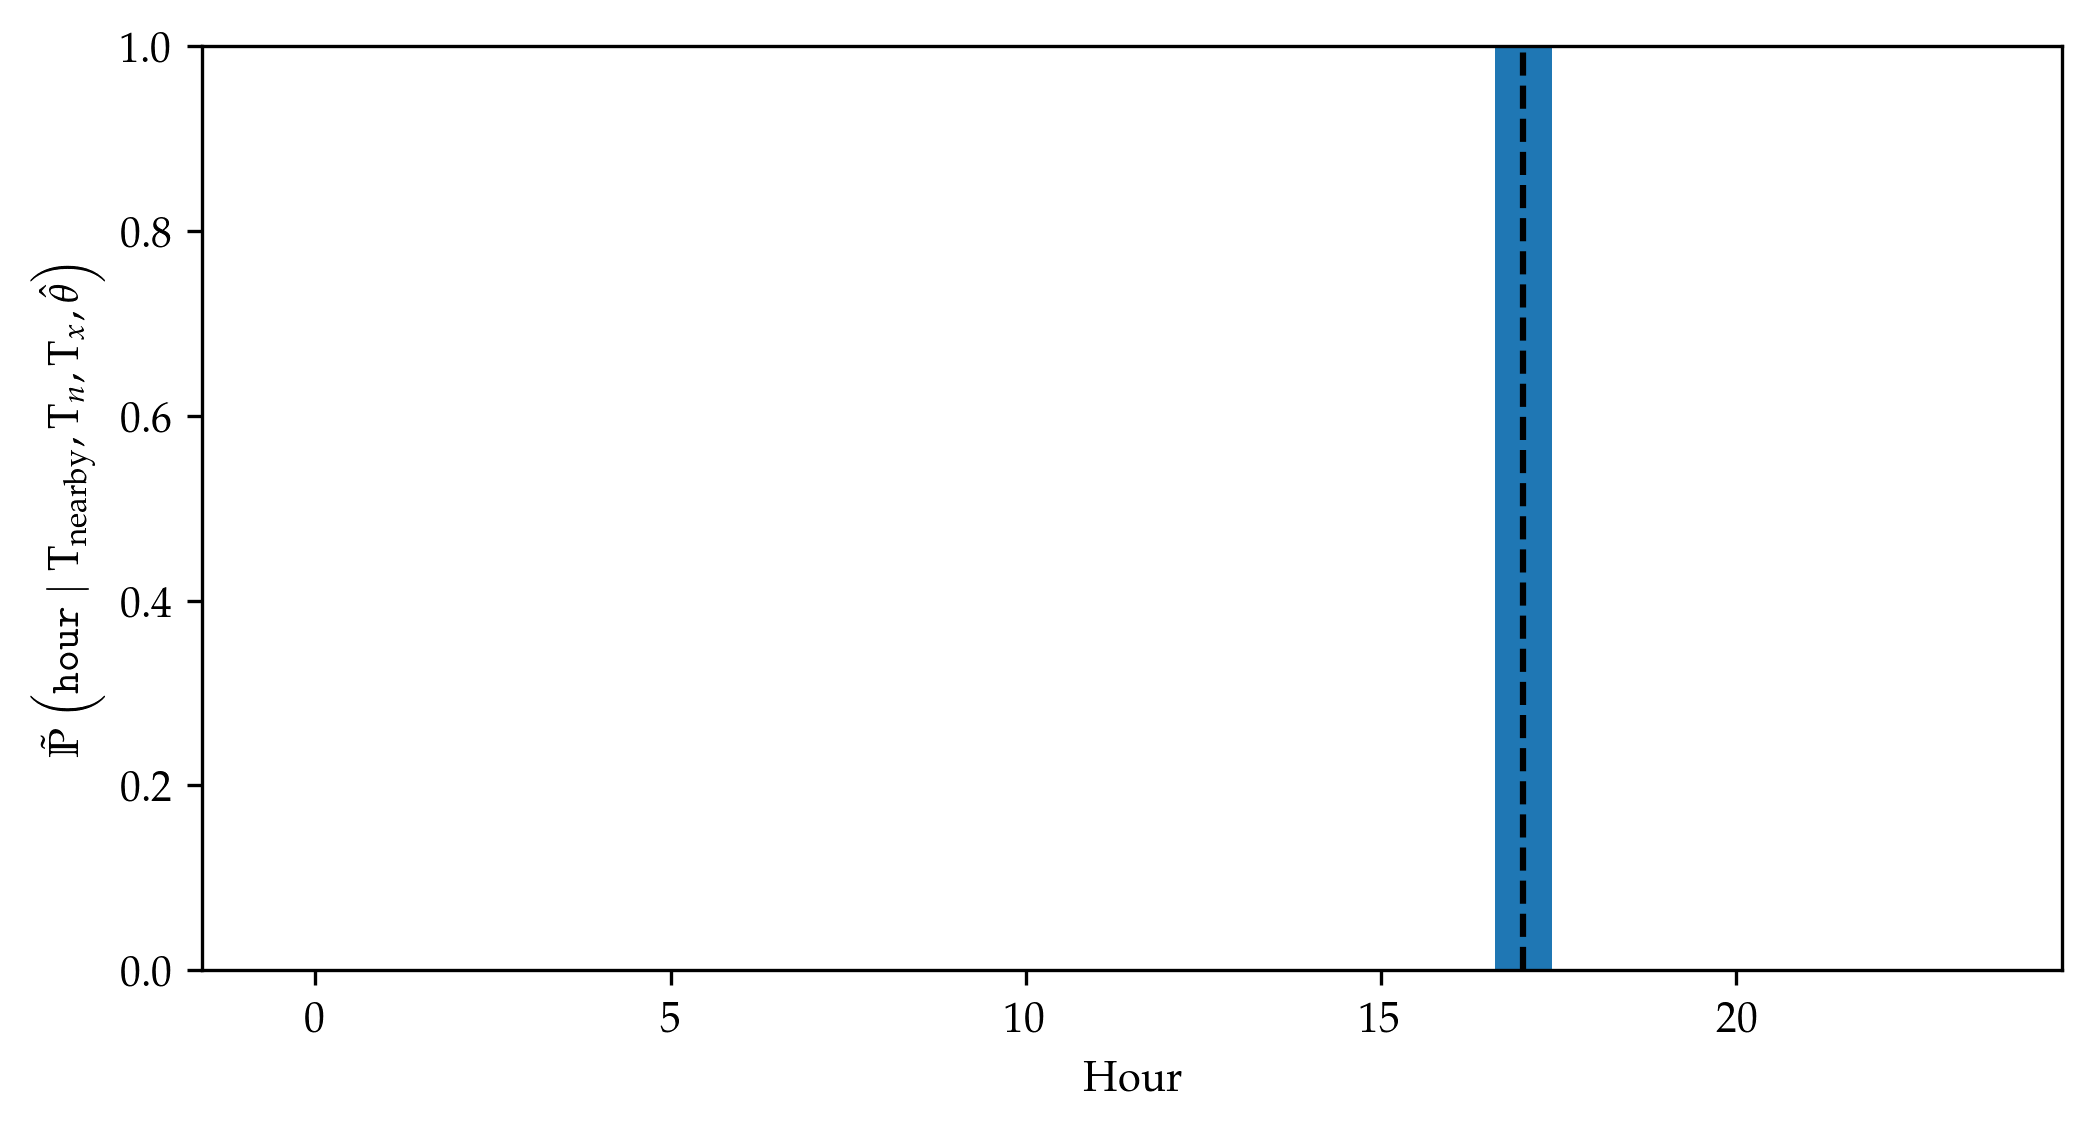

In [27]:
sumloglik_vec = [sumloglik_dict[hr] for hr in hours_vec]
prob_vec = exp.(sumloglik_vec .- maximum(sumloglik_vec) .+ 10)
prob_vec ./= sum(prob_vec)
hours_floats = [h/Hour(1) for h in hours_vec]
plt.bar(hours_floats, prob_vec, linewidth=2)
plt.axvline(17, linestyle="--", color="black")
plt.xlabel("Hour")
plt.ylim(0,1)
# plt.text(3, 1.0, 
#     L"\tilde{\mathbb{P}}\left(\mathtt{hour} \mid \mathrm{T}_{\mathrm{nearby}}, \mathrm{T}_{n}, \mathrm{T}_{x},  \hat{\theta} \right)")
plt.ylabel(L"$\tilde{\mathbb{P}}\left(\mathtt{hour} \mid \mathrm{T}_{\mathrm{nearby}}, \mathrm{T}_{n}, \mathrm{T}_{x},  \hat{\theta} \right)$")
plt.savefig("../figures/hr_pseudo_posterior.png")
plt.savefig("../figures/hr_pseudo_posterior.pdf")

In [45]:
sum([prob_vec[1:16] ; prob_vec[18:end]])

1.0